### 4. Evaluation

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('customer_chun.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [5]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [ 'gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [7]:
dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y__pred = model.predict_proba(X_val)[: , 1]
churn_decision = (y__pred >= 0.5)
(churn_decision == y_val).mean()

0.8034066713981547

#### Accuracy and Dummy

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
threshold = np.linspace(0, 1, 21)

scores = []

for t in threshold:
    #churn_decision = (y__pred >= t)
    #score = (churn_decision == y_val).mean()
    score = accuracy_score(y_val, y__pred >=t)
    print('%.2f %.3f' %(t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


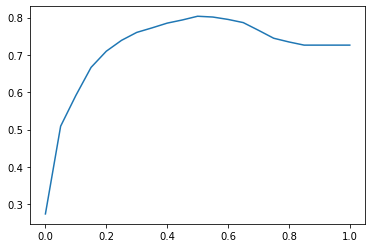

In [11]:
plt.plot(threshold, scores)

In [12]:
from collections import Counter

In [13]:
Counter(y__pred >= 1)

Counter({False: 1409})

#### Confusion Table

In [14]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [15]:
t = 0.5

predict_positive = (y__pred >= t)
predict_negative = (y__pred < t)

In [16]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

tp , tn

(210, 922)

In [17]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

fn, fp

(176, 101)

In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [20]:
confusion_matrix

array([[922, 101],
       [176, 210]])

#### Precison and Recall

In [21]:
# PRECISION 
p = tp/(tp + fp)
p

0.6752411575562701

In [22]:
# RECALL
r = tp/(tp + fn)
r

0.5440414507772021

#### ROC Curve

##### TPR & FPR

In [23]:
tpr = tp / (fn + tp)
tpr

0.5440414507772021

In [24]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [25]:
scores = []

threshold = np.linspace(0, 1, 101)

for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y__pred >= t)
    predict_negative = (y__pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))
    

In [26]:
columns = ['threshold',  'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

In [27]:
df_scores[ : :10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


In [28]:
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


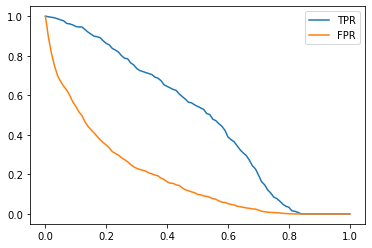

In [29]:
plt.plot(df_scores.threshold, df_scores.tpr, label = 'TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label = 'FPR')
plt.legend()

#### Random Model

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, len(y_val))

In [31]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [32]:
def tpr_fpr_dataframe (y_val, y__pred):
    scores = []

    threshold = np.linspace(0, 1, 101)

    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y__pred >= t)
        predict_negative = (y__pred < t)

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

        columns = ['threshold',  'tp', 'fp', 'fn', 'tn']

    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

    return df_scores

In [33]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [34]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


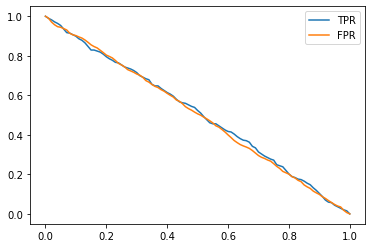

In [35]:
plt.plot(df_rand.threshold, df_rand.tpr, label = 'TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label = 'FPR')
plt.legend()

#### Ideal Model 

In [36]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [37]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [39]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [40]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [41]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


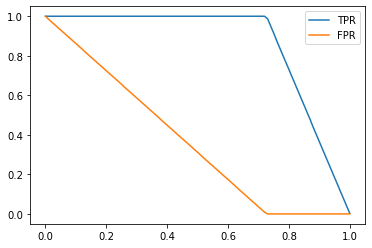

In [42]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label = 'FPR')
plt.legend()

#### Putting everything together

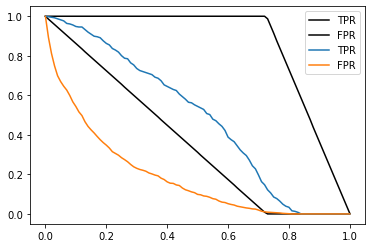

In [43]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label = 'TPR', color= 'black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label = 'FPR', color= 'black')

plt.plot(df_scores.threshold, df_scores.tpr, label = 'TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label = 'FPR')

plt.legend()



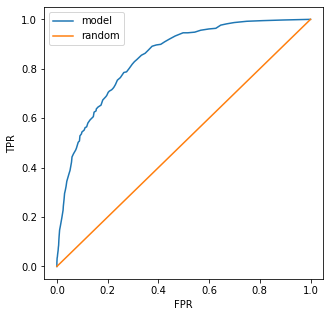

In [49]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label= 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [50]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, thresholds =roc_curve(y_val, y__pred)

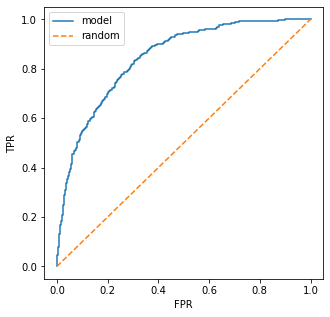

In [54]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle= '--')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label= 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

#### ROC AUC

In [55]:
from sklearn.metrics import auc

In [56]:
auc(fpr, tpr)

0.8438530381535563

In [57]:
fpr, tpr, thresholds =roc_curve(y_val, y__pred)
auc(fpr, tpr)

0.8438530381535563

In [58]:
from sklearn.metrics import roc_auc_score

In [59]:
roc_auc_score(y_val, y__pred)

0.8438530381535563

In [60]:
neg = y__pred[y_val == 0]
pos = y__pred[y_val == 1]

In [61]:
import random

In [64]:
n = 100000
success = 0

for i in range (n):
    pos_idx = random.randint(0, len(pos)-1)
    neg_idx = random.randint(0, len(neg)-1)

    if pos[pos_idx] > neg[neg_idx]:
        success = success + 1

success / n

0.84415

In [73]:
# using numpy
n = 10000

np.random.seed(1)
pos_idx = np.random.randint(0, len(pos), size = n)
neg_idx = np.random.randint(0, len(neg), size= n)

(pos[pos_idx] > neg[neg_idx]).mean()

0.8412